# Regression Trees & Random Forest Regression (apartment data)

In this notebook, we will use Regression Tree and Random Forest Regressors to predict rental apartment prices based on various features like living area, number of rooms and more. We will evaluate the models using goodness-of-fit measures like R-squared.

## Libraries and settings

In [11]:
# Libraries
import os
import re
import time
import fnmatch
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Show current working directory
print(os.getcwd())

/workspaces/python_machine_learning_basics/CART_RandomForest


## Data Preparation

In [12]:
# Import data from csv to pandas dataframe named 'df'
df = pd.read_csv('./Data/autoscout24_data.csv', sep=";", encoding='utf-8')

# Change the column names to lowercase
df.columns = df.columns.str.lower()

# Display the first 5 rows of the dataframe
df.head()

# Count and remove missing values
print("Missing values before removing: ", df.isnull().sum().sum()) # two times sum() = .sum() calculates the total missing values per column. Applying .sum() again sums across all columns, giving the total count of missing values in df.
df = df.dropna() # drop all rows with missing values
print("Missing values after removing: ", df.isnull().sum().sum())

# Reset the index of the dataframe
df = df.reset_index(drop=True) 

# Count and remove duplicates
print("Number of duplicates before removing: ", df.duplicated().sum()) # Applying .sum() on this Series counts True values (i.e., the number of duplicates), because True is treated as 1 and False as 0 in a numerical context.
df = df.drop_duplicates()
print("Number of duplicates after removing: ", df.duplicated().sum())

# Reset the index of the dataframe
df = df.reset_index(drop=True)

# Change strings in 'type' to uppercase and remove leading and trailing whitespaces
df['type'] = df['type'].str.upper().str.strip()

# Display variable 'type'
df['type'].head()

# Extract numerical values (note the 'join' function)
mileage = []
for i in df['mileage_raw']:
    d1 = re.findall("\d+", i) # searches for sequences of digits in the string i. This results in a list of strings containing only numbers found in i (e.g., ['123', '456']).
    try:
        d2 = int(''.join(d1)) #  joins the list of strings into a single string (e.g., ['123', '456'] becomes '123456').
    except:
        d2 = None
    mileage.append(d2)

# Save as new variable in the pandas data frame
df['mileage'] = pd.Series(mileage, dtype="Int64") # change here datatype for mileage

# Extract numerical values (note the 'join' function)
hp = []
for i in df['hp_raw']:
    d1 = re.findall("\d+", i)
    try:
        d2 = int(''.join(d1))
    except:
        d2 = None
    hp.append(d2)

# Save as new variable in the pandas data frame
df['hp'] = pd.Series(hp, dtype="Int64")



# Extract numerical values (note the 'join' function)
price = []
for i in df['price_raw']:
    d1 = re.findall("CHF\s*([\d']+)\.–", i)
    try:
        d2 = d1[0].strip().replace("'", "")
    except:
        d2 = None
    price.append(d2)

# Save as new variable in the pandas data frame
df['price'] = pd.Series(price, dtype="Int64")


# save the cleaned data to a new csv file
df.to_csv('./Data/autoscout24_data_cleaned.csv', sep=";", encoding='utf-8', index=False)

# column names
list(df.columns)


Missing values before removing:  23
Missing values after removing:  0
Number of duplicates before removing:  0
Number of duplicates after removing:  0


['url_short',
 'offer_id',
 'scrape_dt',
 'type',
 'price_raw',
 'hp_raw',
 'init_regist',
 'mileage_raw',
 'fuel_type',
 'transmission',
 'dealer_name',
 'dealer_plz',
 'dealer_city',
 'dealer_street_house_nr',
 'dealer_telnr',
 'init_regist_my',
 'init_regist_month',
 'init_regist_year',
 'init_regist_dt',
 'mileage',
 'hp',
 'price']

In [13]:
df.dtypes

url_short                  object
offer_id                    int64
scrape_dt                  object
type                       object
price_raw                  object
hp_raw                     object
init_regist                object
mileage_raw                object
fuel_type                  object
transmission               object
dealer_name                object
dealer_plz                  int64
dealer_city                object
dealer_street_house_nr     object
dealer_telnr               object
init_regist_my             object
init_regist_month         float64
init_regist_year          float64
init_regist_dt             object
mileage                     Int64
hp                          Int64
price                       Int64
dtype: object

## Import the car data

In [16]:
# Define columns for import
columns = ['url_short',
 'offer_id',
 'scrape_dt',
 'type',
 'init_regist',
 'fuel_type',
 'transmission',
 'dealer_name',
 'dealer_plz',
 'dealer_city',
 'dealer_street_house_nr',
 'dealer_telnr',
 'init_regist_my',
 'init_regist_month',
 'init_regist_year',
 'init_regist_dt',
 'mileage',
 'hp',
 'price']


# Read and select columns
df_orig = pd.read_csv("./Data/autoscout24_data_cleaned.csv", sep=";", encoding='utf-8')[columns]

# Rename variable 'web-scraper-order' to 'apmt_id'
df_orig = df_orig.rename(columns={'offer_id': 'id'})

# Remove missing values
df = df_orig.dropna()
df.head(5)

# Remove duplicates
df = df.drop_duplicates()

# Remove some 'extreme' values
df = df.loc[(df['price'] >= 1000) & # Bereich festlegen (1000-5000)
            (df['price'] <= 100000)]

# Reset index
df = df.reset_index(drop=True)

print(df.shape)
df.head(5)

(3892, 19)


,url_short,id,scrape_dt,type,init_regist,fuel_type,transmission,dealer_name,dealer_plz,dealer_city,dealer_street_house_nr,dealer_telnr,init_regist_my,init_regist_month,init_regist_year,init_regist_dt,mileage,hp,price
0,https://www.autoscout24.ch/7324420,7324420,2020_03_17 07:34:45,AUDI A5 SPORTBACK 3.0 TDI QUATTRO S-TRONIC (LI...,10.2014,Diesel,Automatisiertes Schaltgetriebe,***confidential***,8488,Turbenthal,Mettlenstrasse 3,***confidential***,10.2014,10.0,2014.0,2014-10,75000,245,22500
1,https://www.autoscout24.ch/7512768,7512768,2020_03_17 07:34:55,MERCEDES-BENZ SLK 200 7G-TRONIC (CABRIOLET),6.2013,Benzin,Automat sequentiell,***confidential***,3186,Düdingen,Brugerastrasse 60,***confidential***,6.2013,6.0,2013.0,2013-06,46655,184,23749
2,https://www.autoscout24.ch/7512034,7512034,2020_03_17 07:35:03,MERCEDES-BENZ C 350 AVANTGARDE 4MATIC 7G-TRONI...,6.2011,Benzin,Automat sequentiell,***confidential***,1262,Eysins,1262 Eysins,***confidential***,6.2011,6.0,2011.0,2011-06,138955,306,18500
3,https://www.autoscout24.ch/7512728,7512728,2020_03_17 07:35:06,MERCEDES-BENZ A 45 AMG 4MATIC SPEEDSHIFT 7G-DC...,8.2015,Benzin,Automatisiertes Schaltgetriebe,***confidential***,4314,Zeiningen,Am Stutz 21,***confidential***,8.2015,8.0,2015.0,2015-08,43000,360,36000
4,https://www.autoscout24.ch/7490242,7490242,2020_03_17 07:35:16,AUDI A5 SPORTBACK 2.0 TFSI SPORT QUATTRO S-TRO...,9.2018,Benzin,Automatisiertes Schaltgetriebe,***confidential***,3250,Lyss,3250 Lyss,***confidential***,9.2018,9.0,2018.0,2018-09,43300,252,48500


## Regression Tree
See also: https://data36.com/regression-tree-python-scikit-learn

### Create train and test samples for the regression tree (train = 80%, test = 20% of the data)

In [17]:
# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(df[['mileage', 
                                                        'hp',
                                                        'init_regist_year']], # X = mileage, hp, init_regist_year, unabhängige Variablen
                                                        df['price'], # y = price, abhängige Variable
                                                        test_size=0.20, 
                                                        random_state=42)

# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
      mileage   hp  init_regist_year
3731    96000  396            2003.0
3079    33000   82            2016.0
175    159000  204            2013.0
278     35000  350            2016.0
1074    49751  156            2015.0 

y_train:
3731    17800
3079    11000
175     17100
278     34900
1074    21000
Name: price, dtype: int64


### Fit the regression tree model

In [18]:
# Entscheidungsbaum-Regressor (Regressionsmodel das auf Entscheidungsbaum basiert) erstellt und trainiert, um Vorhersagen für einen Testdatensatz
# DecisionTreeRegressor = Machine-Learning-Modell aus der scikit-learn-Bibliothek, das verwendet wird, um Vorhersagen zu treffen.

# Create decision tree regressor object
reg = DecisionTreeRegressor(random_state=20, max_depth=3) # random_state = zufälliger Startwert, max_depth = Tiefe des Baumes auf drei Ebenen, um eine (Overfitting) zu verhindern

# Train decision tree regressor 
reg = reg.fit(X_train, y_train) 

# Predict the response for test dataset
y_pred = reg.predict(X_test)

### Calculate coefficient of determination (R-squared)

In [19]:
# Calculate coefficient of determination
print('R-squared:', round(r2_score(y_test, y_pred), 4)) # auf vier Dezimalstellen runden


R-squared: 0.5675


### Print text representation of the regression tree

In [20]:
# Text representation of the regression tree
text_representation = tree.export_text(reg, 
                                       feature_names=list(X_train.columns))

# Print text_representation
print(text_representation)

# Die Ausgabe zeigt die Entscheidungsregeln des Baums in einer Art verschachtelten If-Else-Struktur:
# Jede Zeile stellt eine Bedingung in einem Knoten dar, z. B. wie area <= 99.50, dass der Baum sich an dieser Stelle verzweigt.
# Wenn die Bedingung erfüllt ist, folgt der Baum dem rechten Zweig (pop_dens); andernfalls geht es nach links resp. unten zum nächsten area Knotenpunkt.
# Blattknoten am Ende des Baums repräsentieren die vorhergesagten Werte für die Zielvariable.

|--- hp <= 325.50
|   |--- init_regist_year <= 2014.50
|   |   |--- hp <= 179.00
|   |   |   |--- value: [10621.55]
|   |   |--- hp >  179.00
|   |   |   |--- value: [19406.35]
|   |--- init_regist_year >  2014.50
|   |   |--- hp <= 189.00
|   |   |   |--- value: [21421.78]
|   |   |--- hp >  189.00
|   |   |   |--- value: [36905.57]
|--- hp >  325.50
|   |--- mileage <= 82250.00
|   |   |--- mileage <= 29850.00
|   |   |   |--- value: [65963.09]
|   |   |--- mileage >  29850.00
|   |   |   |--- value: [52249.08]
|   |--- mileage >  82250.00
|   |   |--- mileage <= 125294.50
|   |   |   |--- value: [38757.32]
|   |   |--- mileage >  125294.50
|   |   |   |--- value: [24568.88]



### Vizualizing the regression tree

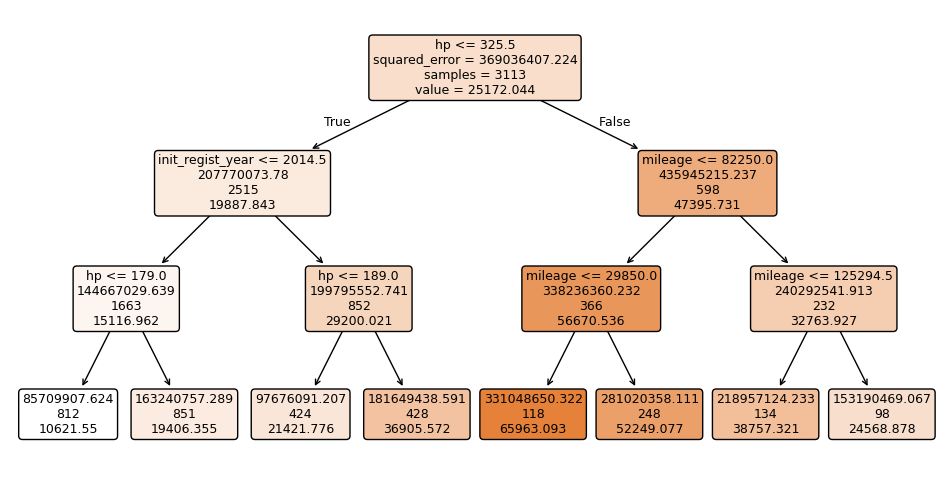

In [21]:
fig = plt.figure(figsize=(12,6))
_ = tree.plot_tree(reg, 
                   feature_names=list(X_train.columns),  
                   class_names=['price'], # Handelt um Regression, gibt es keine Klassen wie bei Klassifikationsmodellen, aber class_names kann eine Bezeichnung für die Zielvariable (abhängige) sein
                   filled=True, #Farbliche Hervorhebung der Knotenpunkte
                   fontsize=9,
                   label='root', #Labels für Knotenpunkte werden angezeigt
                   rounded=True) # Ecken abrunden

## Random Forest Regression
For details see: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

### Create train and test samples for the random forest (train = 80%, test = 20% of the data)

In [22]:
# Create train and test samples (the names X2_ and y2_ were used because X_ and y_ were already used above)
X2_train, X2_test, y2_train, y2_test = train_test_split(df[['mileage', 
                                                            'hp',
                                                            'init_regist_year']], 
                                                            df['price'], 
                                                            test_size=0.20, 
                                                            random_state=42)

# Show X2_train
print('X2_train:')
print(X2_train.head(), '\n')

# Show y2_train
print('y2_train:')
print(y2_train.head())

X2_train:
      mileage   hp  init_regist_year
3731    96000  396            2003.0
3079    33000   82            2016.0
175    159000  204            2013.0
278     35000  350            2016.0
1074    49751  156            2015.0 

y2_train:
3731    17800
3079    11000
175     17100
278     34900
1074    21000
Name: price, dtype: int64


### Fit the Random Forest Regression

In [23]:

reg_rf = RandomForestRegressor(n_estimators=500, # 500 Bäume im Random Forest
                               max_depth=10, # tiefe des Modells anpassen. max 10 Ebenen
                               random_state=5) # auf scikit learn -> randomforest eingeben
reg_rf.fit(X2_train, y2_train)

# Calculate coefficient of determination (R-squared)
print('R-squared:', round(reg_rf.score(X2_test, y2_test), 4))

R-squared: 0.7255


### Show feature importance

Index(['hp', 'init_regist_year', 'mileage'], dtype='object')
[0.5485349 0.2278084 0.2236567]


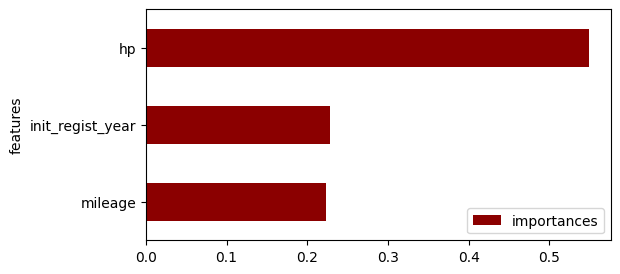

In [24]:
cols = X2_train.columns

# Derive feature importance from random forest
importances = reg_rf.feature_importances_ # Wichtigkeit der Merkmale ermitteln
std         = np.std([tree.feature_importances_ for tree in reg_rf.estimators_], axis=0) # Standardabweichung der Werte um Stabilität zu ermitteln
indices     = np.argsort(importances)[::-1] # sortiert Indizies der Merkmale in absteigender Reihenfolge (wichtigste Merkmale zuerst)

# Print col-names and importances-values
print( cols[indices] )
print( importances[indices] )

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances}) # Dataframe erstellen für Wichtigkeit der Merkmale
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', #barplot horizontal
           y='importances', 
           x='features', 
           color='darkred', 
           figsize=(6,3))

plt.show()

### Jupyter notebook --footer info-- (please always provide this at the end of each submitted notebook)

In [ ]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')